# Robots Limpiadores

En un espacio representado por una cuadrícula de tamaño NxN, cada celda puede estar limpia o sucia. En este entorno, operan varias barredoras eléctricas, que son agentes autónomos responsables de limpiar la cuadrícula. Estas barredoras pueden moverse en las ocho direcciones cardinales: arriba, abajo, izquierda, derecha y las cuatro diagonales.

Cada barredora tiene las siguientes capacidades:
* **Detección:** Puede detectar si la celda donde está limpia o sucia.
* **Limpieza:** Puede limpiar la celda en la que se encuentra.
* **Movimiento:** Puede moverse a una celda adyacente si esta no está ocupada por otra barredora.
* **Posición de arranque:** Todas las celdas en posiciones al azar.

El desafío es desarrollar un sistema multiagentes que limpie la cuadrícula de la manera más eficiente posible. Definimos eficiencia como la relación entre el número de celdas limpiadas y el número de celdas recorridas por un agente.

In [1]:
# Requiero Mesa > 3.0.3
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen de forma aleatoria.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# Haremos uso de ''batch_run'' para ejecutar varias simulaciones
from mesa.batchrunner import batch_run

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [2]:
class Stack:
    def __init__(self):
        self.__data = []
    
    def empty(self):
        return not self.__data
    
    def clear(self):
        self.__data.clear()
    
    def push(self, element):
        self.__data.append(element)
    
    def pop(self):
        if self.__data: # not empty
            self.__data.pop()
        else:
            raise Exception("No such element")
    
    def top(self):
        if self.__data: # not empty
            return self.__data[-1]
        else:
            raise Exception("No such element")
            
    def display(self):
        print(self.__data)

In [46]:
class RobotSweep(Agent):
    def __init__(self, model):
        super().__init__(model)
        self.cells_cleaned = 0
        self.cells_visited = 1
        self.previous_steps = Stack()

    def move(self):
        possible_positions = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        options = np.random.permutation(len(possible_positions))

        hasMove = False
        for i in options:
            position = possible_positions[i]
            (x, y) = position
            if self.model.grid.is_cell_empty(position) and self.model.visited_cells[x][y] == 0:
                self.previous_steps.push(self.pos)
                self.model.grid.move_agent(self, position)
                self.cells_visited += 1
                self.model.visited_cells[x][y] = 1
                hasMove = True
                break

        if not hasMove:
            if self.previous_steps.empty():
                return
                
            position = self.previous_steps.top()
            if self.model.grid.is_cell_empty(position):
                self.previous_steps.pop()
                self.model.grid.move_agent(self, position)
                self.cells_visited += 1
        
    def step(self):
        if self.model.is_all_clean():
            return
            
        (x, y) = self.pos
        if self.model.cells[x][y] == 1:
            self.model.cells[x][y] = 0
            self.cells_cleaned += 1
        else:
            self.move()

In [47]:
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for content, (x, y) in model.grid.coord_iter():
        grid[x][y] = model.cells[x][y]
        if content != None:
            grid[x][y] = 2
    return grid

In [58]:
class RobotSweepModel(Model):
    def __init__(self, width=20, height=20, agents=5, percentage_dirty_cells=10):
        super().__init__()

        self.grid = SingleGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters={"Grid":get_grid, 
                             "Steps":lambda model : model.steps,
                             "Clean":lambda model : 1 - (model.cells.sum() / model.cells.size)},
            agent_reporters={"Efficiency":lambda agent : agent.cells_cleaned / agent.cells_visited})

        self.visited_cells = np.zeros( (width, height) )

        self.cells = np.zeros( (width, height) )
        count = int( (width * height * (percentage_dirty_cells / 100)) )
        while (count > 0):
            x = self.random.randrange(width)
            y = self.random.randrange(height)
            if self.cells[x][y] == 0:
                self.cells[x][y] = 1
                count -= 1 
        
        self.steps = 0

        i = 0
        while (i < agents):
            x = self.random.randrange(width)
            y = self.random.randrange(height)
            if self.grid.is_cell_empty( (x, y) ):
                agent = RobotSweep(self)
                self.grid.place_agent(agent, (x, y))
                self.schedule.add(agent)
                i += 1

    def step(self):
        #if not(self.is_all_clean()):
        #    self.steps += 1
        
        self.datacollector.collect(self)
        self.schedule.step()

    def is_all_clean(self):
        return (self.cells.sum() == 0)

In [59]:
# Registramos el tiempo de inicio y ejecutamos la simulación
start_time = time.time()

model = RobotSweepModel()
while not(model.is_all_clean()):
    model.step()
    
# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))

Tiempo de ejecución: 0:00:00.065693


/tmp/ipykernel_7060/3082018751.py:6: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


In [ ]:
all_agents_info = model.datacollector.get_agent_vars_dataframe()
all_agents_info.info()

In [60]:
# Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.
all_grids = model.datacollector.get_model_vars_dataframe()
all_grids.info()

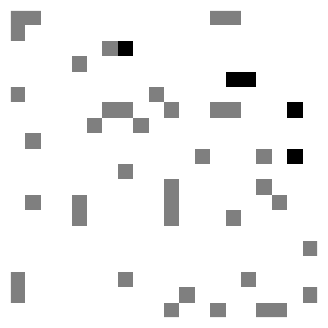

In [61]:
# Graficamos la información usando `matplotlib`
# %%capture

fig, axs = plt.subplots(figsize=(4,4))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grids.iloc[0, 0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grids.iloc[i, 0])
    
anim = animation.FuncAnimation(fig, animate, frames=model.steps)

In [62]:
anim

In [64]:
params = {"width":20, "height":20, "agents":range(5, 25, 5), "percentage_dirty_cells":10}

MAX_SIMULATIONS = 10
MAX_ITERATIONS = 2000

results = batch_run(
    RobotSweepModel,
    parameters=params,
    iterations=MAX_SIMULATIONS,
    max_steps=MAX_ITERATIONS,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipykernel_7060/3082018751.py:6: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


In [65]:
df = pd.DataFrame(results)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000040 entries, 0 to 1000039
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   RunId                   1000040 non-null  int64  
 1   iteration               1000040 non-null  int64  
 2   Step                    1000040 non-null  int64  
 3   width                   1000040 non-null  int64  
 4   height                  1000040 non-null  int64  
 5   agents                  1000040 non-null  int64  
 6   percentage_dirty_cells  1000040 non-null  int64  
 7   Grid                    1000040 non-null  object 
 8   Steps                   1000040 non-null  int64  
 9   Clean                   1000040 non-null  float64
 10  AgentID                 1000000 non-null  float64
 11  Efficiency              1000000 non-null  float64
dtypes: float64(3), int64(8), object(1)
memory usage: 91.6+ MB


In [66]:
average_steps_per_runid = df.groupby('RunId')['Steps'].mean().reset_index()
print(average_steps_per_runid)

    RunId        Steps
0       0  1001.399960
1       1  1001.449978
2       2  1001.466651
3       3  1001.474988
4       4  1001.399960
5       5  1001.449978
6       6  1001.466651
7       7  1001.474988
8       8  1001.399960
9       9  1001.449978
10     10  1001.466651
11     11  1001.474988
12     12  1001.399960
13     13  1001.449978
14     14  1001.466651
15     15  1001.474988
16     16  1001.399960
17     17  1001.449978
18     18  1001.466651
19     19  1001.474988
20     20  1001.399960
21     21  1001.449978
22     22  1001.466651
23     23  1001.474988
24     24  1001.399960
25     25  1001.449978
26     26  1001.466651
27     27  1001.474988
28     28  1001.399960
29     29  1001.449978
30     30  1001.466651
31     31  1001.474988
32     32  1001.399960
33     33  1001.449978
34     34  1001.466651
35     35  1001.474988
36     36  1001.399960
37     37  1001.449978
38     38  1001.466651
39     39  1001.474988


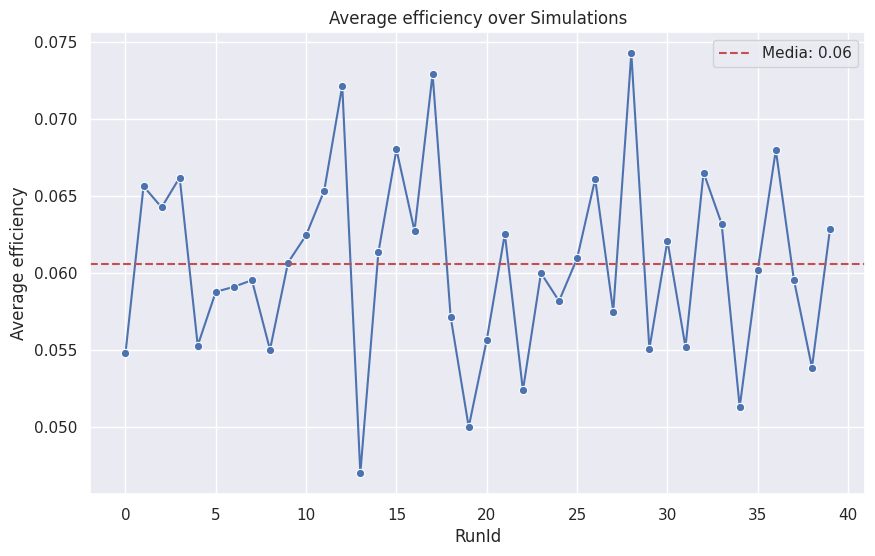

In [75]:
# Agrupamos por RunId y calculamos el promedio de Efficiency para cada grupo
efficiency_avg_by_runid = df.groupby('RunId')['Efficiency'].mean().reset_index()

# Calculamos la media de todos los promedios de Efficiency
mean_efficiency_avg = efficiency_avg_by_runid['Efficiency'].mean()

# Creamos la gráfica
plt.figure(figsize=(10, 6))
sns.lineplot(x='RunId', y='Efficiency', data=efficiency_avg_by_runid, marker='o')

# Añadimos una línea horizontal para marcar la media
plt.axhline(mean_efficiency_avg, color='r', linestyle='--', label=f'Media: {mean_efficiency_avg:.2f}')

# Añadimos etiquetas y título
plt.xlabel('RunId')
plt.ylabel('Average efficiency')
plt.title("Average efficiency over Simulations")
plt.legend()
plt.show()

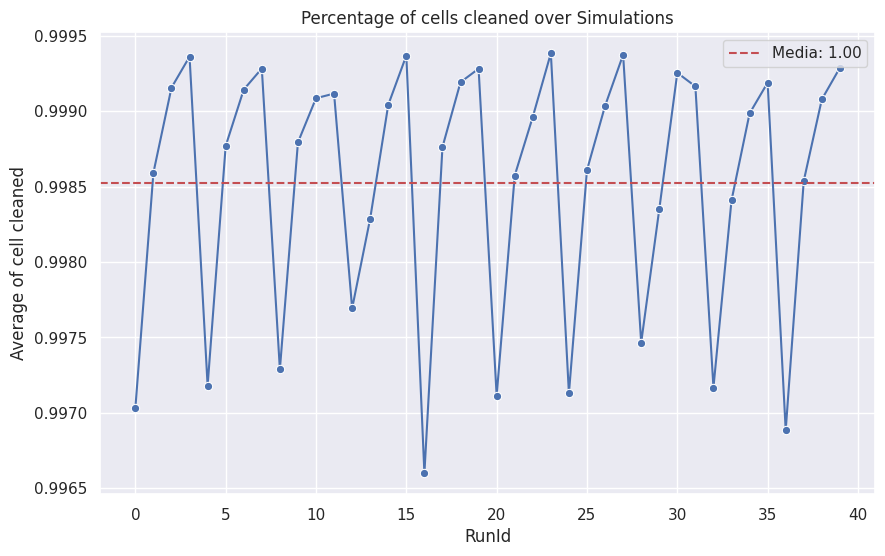

In [77]:
# Agrupamos por RunId y calculamos el promedio de Clean para cada grupo
clean_avg_by_runid = df.groupby('RunId')['Clean'].mean().reset_index()

# Calculamos la media de todos los promedios de Clean
mean_clean_avg = clean_avg_by_runid['Clean'].mean()

# Creamos la gráfica
plt.figure(figsize=(10, 6))
sns.lineplot(x='RunId', y='Clean', data=clean_avg_by_runid, marker='o')

# Añadimos una línea horizontal para marcar la media
plt.axhline(mean_clean_avg, color='r', linestyle='--', label=f'Media: {mean_clean_avg:.2f}')

# Añadimos etiquetas y título
plt.xlabel('RunId')
plt.ylabel('Average of cell cleaned')
plt.title('Percentage of cells cleaned over Simulations')
plt.legend()
plt.show()

In [71]:
for id in range(1, 26):
    robot_data = df[df['AgentID'] == id]
    
    # Calcula las métricas de eficiencia
    average_efficiency = robot_data['Efficiency'].mean()
    min_efficiency = robot_data['Efficiency'].min()
    max_efficiency = robot_data['Efficiency'].max()
    
    print(f"Eficiencia promedio del Robot {id}: {average_efficiency}")
    print()

Eficiencia promedio del Robot 1: 0.06187764052321171

Eficiencia promedio del Robot 2: 0.06340319827819148

Eficiencia promedio del Robot 3: 0.05712869991577775

Eficiencia promedio del Robot 4: 0.06561710832379523

Eficiencia promedio del Robot 5: 0.06523777555727821

Eficiencia promedio del Robot 6: 0.07157872421937336

Eficiencia promedio del Robot 7: 0.06269037862831212

Eficiencia promedio del Robot 8: 0.06452141540765007

Eficiencia promedio del Robot 9: 0.05843634066742501

Eficiencia promedio del Robot 10: 0.06398368157301651

Eficiencia promedio del Robot 11: 0.048949537431951164

Eficiencia promedio del Robot 12: 0.054133050455786494

Eficiencia promedio del Robot 13: 0.06420870561570653

Eficiencia promedio del Robot 14: 0.04913926574011695

Eficiencia promedio del Robot 15: 0.055854062739710435

Eficiencia promedio del Robot 16: 0.05528123653634408

Eficiencia promedio del Robot 17: 0.050124762424417886

Eficiencia promedio del Robot 18: 0.06078692798164621

Eficiencia prom

In [73]:
average_efficiency_by_agents = df.groupby('agents')['Efficiency'].mean()

print(average_efficiency_by_agents)

agents
5     0.062255
10    0.060627
15    0.058992
20    0.060477
Name: Efficiency, dtype: float64


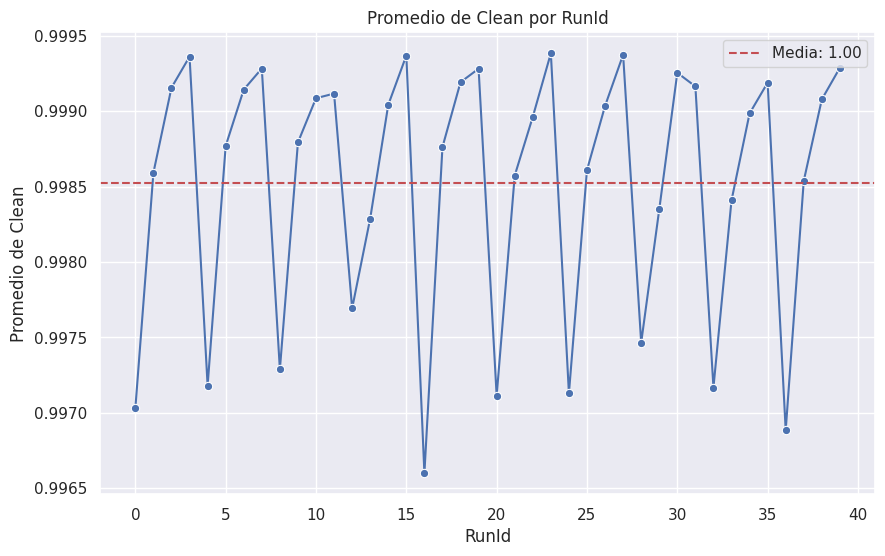

In [74]:
# Supongamos que tu DataFrame se llama df
# Agrupamos por RunId y calculamos el promedio de Clean para cada grupo
clean_avg_by_runid = df.groupby('RunId')['Clean'].mean().reset_index()

# Calculamos la media de todos los promedios de Clean
mean_clean_avg = clean_avg_by_runid['Clean'].mean()

# Creamos la gráfica
plt.figure(figsize=(10, 6))
sns.lineplot(x='RunId', y='Clean', data=clean_avg_by_runid, marker='o')

# Añadimos una línea horizontal para marcar la media
plt.axhline(mean_clean_avg, color='r', linestyle='--', label=f'Media: {mean_clean_avg:.2f}')

# Añadimos etiquetas y título
plt.xlabel('RunId')
plt.ylabel('Promedio de Clean')
plt.title('Promedio de Clean por RunId')
plt.legend()
plt.show()

In [78]:
average_efficiency_by_agents = df.groupby('agents')['Efficiency'].mean()
print(average_efficiency_by_agents)

agents
5     0.062255
10    0.060627
15    0.058992
20    0.060477
Name: Efficiency, dtype: float64
